In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Import Data

In [2]:
# import train data
df_train = pd.read_csv('train.csv')
df_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
# check for missing data
df_train.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [4]:
# check datatypes
df_train.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

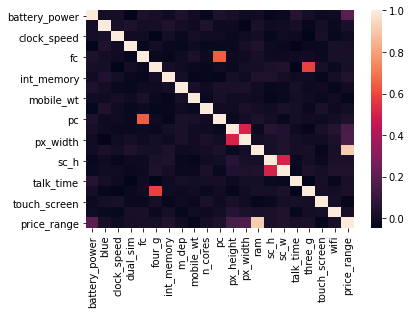

In [5]:
# check correlation
sns.heatmap(df_train.corr())

### Feature Selection

In [7]:
# split features and labels
X = df_train[df_train.columns[:-1]]
y = df_train.price_range

In [8]:
# using feature selection module
from feature_selector import FeatureSelector
fs = FeatureSelector(data = X,labels=y)

In [9]:
# check for attributes with more than 80% correlation
fs.identify_collinear(correlation_threshold=0.8)
collinear_features = fs.ops['collinear']
fs.record_collinear.head()

0 features with a correlation magnitude greater than 0.80.



,drop_feature,corr_feature,corr_value


In [10]:
# check for zero importance features
fs.identify_zero_importance(task='classification',n_iterations=5,early_stopping=False)

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.



In [11]:
# extract features with cumulative importance of 95% using lightgbm model
fs.identify_low_importance(cumulative_importance=0.95)

13 features required for cumulative importance of 0.95 after one hot encoding.
7 features do not contribute to cumulative importance of 0.95.



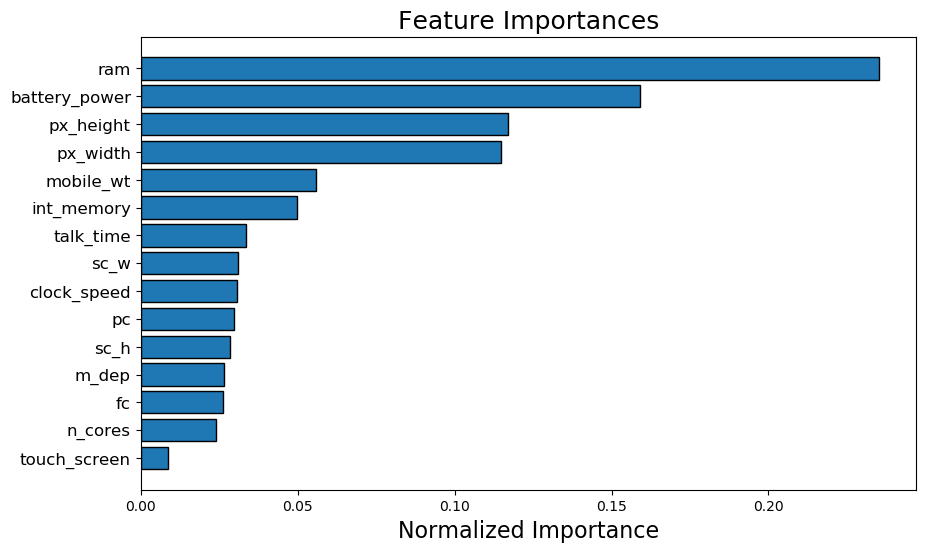

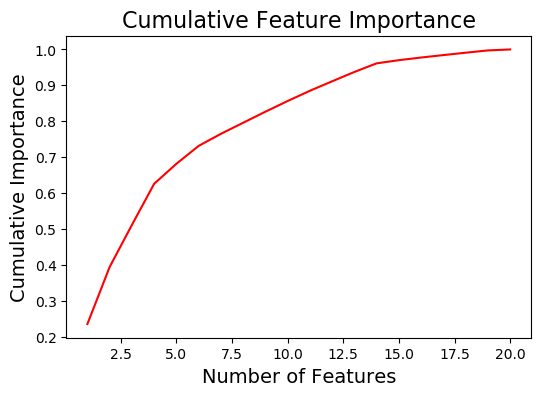

In [12]:
# check the importances of features
fs.plot_feature_importances()

In [13]:
# check the importances of features
feature_importances = pd.DataFrame(fs.feature_importances)
feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,ram,18031.0,0.235155,0.235155
1,battery_power,12192.0,0.159005,0.394160
2,px_height,8967.0,0.116945,0.511105
3,px_width,8794.0,0.114689,0.625794
4,mobile_wt,4272.0,0.055714,0.681508
5,int_memory,3818.0,0.049793,0.731301
6,talk_time,2578.0,0.033622,0.764923
7,sc_w,2366.0,0.030857,0.795780
8,clock_speed,2362.0,0.030805,0.826584
9,pc,2281.0,0.029748,0.856332


In [14]:
# remove the features with less than 5% cumulative importance
X_removed = fs.remove(methods = ['low_importance'])
retained_columns = X_removed.columns

Removed 7 features.


In [15]:
# apply mimmaxscaler on features
X_tranformed = X.copy()
for column in X.columns:
    X_tranformed[column] = MinMaxScaler().fit_transform(X[column].values.reshape(-1, 1))

### Modeling

In [18]:
model_dict= {'LogisticRegression': LogisticRegression(),
             'Decision Tree Regression': DecisionTreeClassifier(),
             'RandomForestClassifier':RandomForestClassifier(),
             'ExtraTreesClassifier':ExtraTreesClassifier(),
             'XGBClassifier':XGBClassifier(verbose=0),
             'CatBoostClassifier':CatBoostClassifier(verbose=0),
            }

In [19]:
# split dataset into 70-30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=76)
# check the performance of models on all features
for classifier_name, classifier in model_dict.items():
    classifier.fit(X_train,y_train)
    print(classifier_name,' - ',classifier.score(X_test,y_test))

LogisticRegression  -  0.7766666666666666
Decision Tree Regression  -  0.8433333333333334
RandomForestClassifier  -  0.795
ExtraTreesClassifier  -  0.7683333333333333
XGBClassifier  -  0.895
CatBoostClassifier  -  0.93


In [20]:
# split dataset into 70-30 
X_train, X_test, y_train, y_test = train_test_split(X_tranformed, y, test_size=0.3, random_state=76)
# check the performance of models on scaled data features
for classifier_name, classifier in model_dict.items():
    classifier.fit(X_train,y_train)
    print(classifier_name,' - ',classifier.score(X_test,y_test))

LogisticRegression  -  0.8116666666666666
Decision Tree Regression  -  0.85
RandomForestClassifier  -  0.8116666666666666
ExtraTreesClassifier  -  0.7066666666666667
XGBClassifier  -  0.895
CatBoostClassifier  -  0.93


In [21]:
# split dataset into 70-30 
X_train, X_test, y_train, y_test = train_test_split(X_removed, y, test_size=0.3, random_state=76)
# check the performance of models on reatined features
for classifier_name, classifier in model_dict.items():
    classifier.fit(X_train,y_train)
    print(classifier_name,' - ',classifier.score(X_test,y_test))

LogisticRegression  -  0.7866666666666666
Decision Tree Regression  -  0.86
RandomForestClassifier  -  0.805
ExtraTreesClassifier  -  0.7983333333333333
XGBClassifier  -  0.9016666666666666
CatBoostClassifier  -  0.9316666666666666


- Catboost with  removed features gives best accuracy

### Parameter Tuning

In [22]:
# selecting optimal number of iterations using catboost classifier
for iterations in [500,1000,2000,3000,5000]:
    classifier = CatBoostClassifier(verbose=0,iterations=iterations)
    classifier.fit(X_train,y_train)
    print(iterations,' - ',classifier.score(X_test,y_test))

500  -  0.9266666666666666
1000  -  0.9316666666666666
2000  -  0.9316666666666666
3000  -  0.93
5000  -  0.93


### Final Prediction 

In [23]:
# import test data set
df_test = pd.read_csv('test.csv')
df_test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [24]:
# using catboost with 3k iterations and less features
classifier = CatBoostClassifier(verbose=0,iterations=2000)
classifier.fit(X_removed,y)

X_valid = df_test[retained_columns]
y_pred = classifier.predict(X_valid)

In [25]:
y_pred

array([[3.],
       [3.],
       [2.],
       [3.],
       [1.],
       [3.],
       [3.],
       [1.],
       [3.],
       [0.],
       [3.],
       [3.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [1.],
       [3.],
       [2.],
       [1.],
       [3.],
       [1.],
       [1.],
       [3.],
       [0.],
       [2.],
       [0.],
       [3.],
       [0.],
       [2.],
       [0.],
       [3.],
       [0.],
       [1.],
       [1.],
       [3.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [3.],
       [1.],
       [2.],
       [1.],
       [0.],
       [3.],
       [0.],
       [3.],
       [1.],
       [3.],
       [1.],
       [1.],
       [3.],
       [3.],
       [2.],
       [0.],
       [1.],
       [1.],
       [1.],
       [2.],
       [3.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [3.],
       [3.],
       [0.],
       [2.],